# System identification 7m with 7m VCT prior

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
ships

['M5064-02-A', 'wPCC', '7m']

In [5]:
%reload_kedro
ship='7m'
prior_ship = 'wPCC'
time_series = catalog.load(f"{ship}.tests")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.test_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
#time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)

[05/16/23 08:25:55] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=190367;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=945944;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/16/23 08:25:55] INFO     Kedro project phd                                                      ]8;id=32870;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=370494;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=263264;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=258696;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=119240;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=62189;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=763963;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=403370;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=481216;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=752775;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=751984;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=188484;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [6]:
ship_data_prior_ship = catalog.load(f"{prior_ship}.ship_data")

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=98090;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=920921;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [7]:
ship_data

{'T': 0.284,
 'L': 7.0,
 'B': 1.3,
 'rho': 1025,
 'x_G': 0,
 'm': 1155,
 'I_z': 3386.0314842592607,
 'volume': 1.063551724137931,
 'CB': 0.41152752056103203,
 'x_r': -3.3168459992407717,
 'scale_factor': 30,
 'TWIN': 1,
 'D': 0.17}

In [8]:
time_series_meta_data['tws'] = (time_series_meta_data['twsBow'] + time_series_meta_data['twsStern'])/2

<Axes: xlabel='date'>

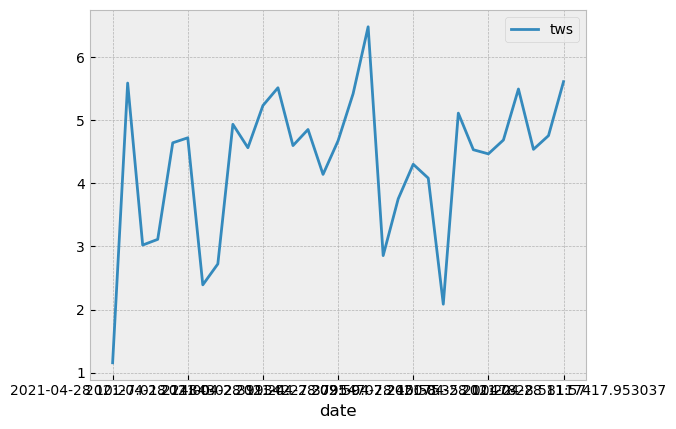

In [9]:
time_series_meta_data.plot(x='date', y='tws')

In [10]:
time_series_meta_data['delta_abs'] = time_series_meta_data['delta'].abs()
time_series_meta_data.sort_values(by='date', ascending=True)

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,delta,V,beta,u,v,psi,phi,r,u1d,v1d,r1d,y_GPS,x_GPS,x0,y0,zigzag_test_id,inbetween_zigzags_id,date,type,time_series,tws,delta_abs
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15,6.2832,6.2832,2.5325,37.1500,37.1500,59.296869,18.325073,0.1659,3.1397,6.3564,3.1409,4.7770,2.8899,6.2551,3.1399,4.5715,104.0,3.1556,0.0551,0.5400,0.2003,0.2861,0.8060,1.6052,12.1582,3.1241,6.9889,3.1416,5.0559,3.1241,6.8861,4.9732,0.648390,2.5325,7.185385,2.530865,1.477312,9.615285,0.1659,0.284523,0.933245,1.710204,0.467414,392.871852,1962.112717,1960.620546,391.807225,NaN,15.0,2021-04-28 09:59:07.245075,inbetween,motoring_7m_all_data,4.67425,0.648390
0,4.6142,4.5255,2.4869,12.2867,12.3059,59.291708,18.324195,0.0556,0.4431,2.3618,3.1312,1.2123,0.5961,2.5882,3.1120,1.1035,100.0,3.1556,0.0261,0.1161,0.0359,0.1113,0.2998,1.1207,10.4167,0.5236,2.5156,3.0692,1.3705,0.6458,2.8809,1.2000,0.214778,2.4869,6.585485,2.447543,0.661586,10.897385,0.0556,0.113965,0.228417,0.523831,0.211835,339.869303,1387.282236,1384.530613,339.744214,0.0,NaN,2021-04-28 10:27:01.224843,zigzag,motoring_7m_all_data,1.15790,0.214778
16,6.2797,6.2812,2.5697,37.1500,37.1500,59.290375,18.323986,0.1032,3.1280,6.9156,3.1376,5.7343,3.1110,6.3081,3.1288,5.1044,100.0,4.8869,0.0595,0.3440,0.2972,0.2725,0.6759,1.5309,13.5755,3.1241,7.2022,3.1315,6.0076,3.1241,6.6749,5.4748,0.648390,2.5697,7.124185,2.388635,1.394426,22.419841,0.1032,0.283592,1.373957,2.421416,0.404403,326.647672,1238.905582,1236.815852,324.933296,NaN,16.0,2021-04-28 10:28:31.023738,inbetween,motoring_7m_all_data,5.41935,0.648390
1,3.5568,3.6466,2.3885,12.5921,12.5381,59.283688,18.323452,0.0613,0.8018,7.9267,1.2375,5.6938,0.7847,7.7081,1.2010,5.4819,100.0,3.1416,0.0168,0.1171,0.0458,0.1139,0.2819,0.9820,10.5981,0.9425,8.5390,1.3663,6.2561,0.8727,8.1744,5.9537,0.218831,2.3885,6.639285,2.388489,0.714082,22.768641,0.0613,0.127475,0.481107,1.018159,0.299873,290.883099,494.211045,491.438685,293.171998,1.0,NaN,2021-04-28 10:41:19.614095,zigzag,motoring_7m_all_data,5.58785,0.218831
17,6.2806,6.2826,2.4072,37.1500,37.1500,59.285992,18.325294,0.1343,3.1365,8.0136,3.1377,6.7439,3.1398,7.9639,3.1402,6.2145,100.0,6.1087,0.0284,0.5069,0.1105,0.2574,0.4428,1.3519,11.8275,3.1401,8.4345,3.1396,7.3885,3.1302,8.4340,6.7166,0.648390,2.4072,7.141785,2.400841,1.445041,26.476127,0.1343,0.252033,0.649759,3.339849,0.312562,396.798411,750.571257,753.251422,395.204890,NaN,17.0,2021-04-28 10:42:51.812923,inbetween,motoring_7m_all_data,6.47920,0.648390
2,6.2807,6.2821,2.2624,12.7166,12.7703,59.287654,18.323811,0.0995,3.0958,2.4178,3.1381,3.0032,3.1215,2.1305,3.1373,3.0415,80.0,6.1087,0.0184,0.2811,0.0477,0.1028,0.2036,0.9736,10.6415,3.1241,2.7780,3.1296,3.3802,3.1241,2.6534,3.3126,0.222884,2.2624,6.652171,2.215301,0.739841,25.621227,0.0995,0.111463,0.287604,1.433933,0.215152,314.133968,935.785387,938.530517,313.316988,2.0,NaN,2021-04-28 10:49:38.207640,zigzag,motoring_7m_all_data,3.02235,0.222884
18,6.2396,6.2826,2.2613,36.9535,35.0216,59.289725,18.323823,0.0873,3.1156,2.4835,3.1350,2.9898,3.0903,2.3529,3.1204,2.7208,80.0,6.1087,0.0142,0.2666,0.0399,0.2161,0.2435,1.0782,10.4329,3.1241,2.5722,3.1416,3.1023,3.1032,2.6626,2.9173,0.611242,2.2613,6.523185,2.207731,1.055443,25.664027,0.0873,0.228458,0.303051,1.295632,0.242817,316.123877,1166.710664,1169.279338,314.655255,NaN,18.0,2021-04-28 10:51:13.006411,inbetween,motoring_7m_all_data,2.85530,0.611242
3,6.2830,6.2784,2.1663,11.0927,11.1450,59.291236,18.323118,0.0583,3.0320,2.2336,3.1411,3.1125,3.0690,2.2329,3.1356,3.1128,80.0,6.1087,0.0165,0.1085,0.0277,0.0903,0.2002,0.8505,10.3556,3.1241,2.6274,3.1416,3.3891,3.1241,2.5722,3.4658,0.194517,2.1663,6.540571,2.155465,0.677368,26.242827,0.0583,0.095506,0.189455,0.620825,0.1649

In [11]:
id = "4"
data_raw = time_series[str(id)]()
data_raw.drop(columns=['date'], inplace=True)

data_raw = fix_interpolated_angle(data=data_raw, key="awaBowRAW")
data_raw = fix_interpolated_angle(data=data_raw, key="awaSternRAW")
data_raw = fix_interpolated_angle(data=data_raw, key="awaBow")
data_raw = fix_interpolated_angle(data=data_raw, key="awaStern")

[05/16/23 08:25:56] INFO     fix_interpolated_angle for awaBowRAW                                      ]8;id=542323;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py\nodes.py]8;;\:]8;id=291134;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py#127\127]8;;\

                    INFO     fix_interpolated_angle for awaSternRAW                                    ]8;id=256534;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py\nodes.py]8;;\:]8;id=110439;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py#127\127]8;;\

                    INFO     fix_interpolated_angle for awaBow                                         ]8;id=71918;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py\nodes.py]8;;\:]8;id=747149;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py#127\127]8;;\

                    INFO     fix_interpolated_angle for awaStern                                       ]8;id=412759;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py\nodes.py]8;;\:]8;id=529834;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py#127\127]8;;\

In [12]:
data_raw.head()

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,mission,delta,V,beta,u,v,psi,phi,r,u1d,v1d,r1d,y_GPS,x_GPS,x0,y0,global time
time(us),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,6.1214,6.1198,1.7796,3.4409,3.2506,59.293256,18.321301,0.0212,-2.8797,1.7941,-3.0216,3.5383,-2.9234,2.2584,-3.0280,4.0127,60.0,6.1087,0.0068,-0.0276,0.0007,0.0057,0.0414,-0.1681,-9.8297,-2.8449,1.9034,-3.0297,3.6423,-2.9671,2.6751,4.4382,"ZigZag: start (59.29325104,18.32130241),ZigZag...",-0.056734,1.7796,6.284785,1.779598,-0.002847,-25.294527,0.0212,0.005502,0.010425,-0.025860,-0.020016,176.314069,1560.669215,1563.313438,175.380951,3464.356878
0.199930,6.1225,6.1180,1.7817,13.4409,3.4028,59.293259,18.321300,0.0149,-2.8771,1.8055,-3.0188,3.5494,-2.9256,2.2867,-3.0279,4.0416,60.0,6.1087,0.0073,-0.0276,0.0035,0.0038,0.0517,-0.2036,-9.7909,-2.8449,1.9351,-3.0099,3.6745,-2.9563,2.6434,4.4056,NaN,-0.059390,1.7817,6.287685,1.781682,-0.008018,-25.293427,0.0149,0.001500,-0.021018,0.083642,0.035005,176.258192,1561.044756,1563.690004,175.327983,3464.556808
0.399917,6.1228,6.1277,1.7775,13.4409,5.4571,59.293262,18.321299,0.0103,-2.8766,1.8093,-3.0176,3.5534,-2.9255,2.3067,-3.0269,4.0616,60.0,6.1087,0.0080,-0.0114,0.0033,0.0043,0.0788,-0.0270,-9.7854,-2.8641,1.8794,-2.9909,3.6236,-2.9304,2.5670,4.3234,NaN,-0.095244,1.7775,6.278285,1.777479,0.008710,-25.293127,0.0103,0.008501,0.012584,0.121129,-0.035008,176.207806,1561.406866,1564.052393,175.278391,3464.756795
0.599902,6.1245,6.1430,1.7803,13.4409,9.2897,59.293265,18.321299,0.0105,-2.8786,1.8041,-3.0184,3.5489,-2.9236,2.3185,-3.0253,4.0730,60.0,6.1087,0.0081,0.0155,-0.0027,0.0079,0.0202,-0.2320,-9.7727,-2.9014,1.7430,-3.0237,3.4965,-2.8993,2.4632,4.2122,NaN,-0.162136,1.7803,6.264685,1.779995,0.032934,-25.291427,0.0105,0.001500,0.015106,-0.005961,0.039984,176.164274,1561.756841,1564.403944,175.239357,3464.956780
0.799961,6.1248,6.1426,1.7833,13.4409,11.8712,59.293269,18.321298,0.0146,-2.8826,1.7960,-3.0207,3.5424,-2.9229,2.3261,-3.0251,4.0809,60.0,6.1087,0.0072,0.0268,-0.0060,0.0106,0.0358,-0.3286,-9.8280,-2.9276,1.7044,-3.0231,3.4682,-2.9124,2.4246,4.1824,NaN,-0.207192,1.7833,6.265385,1.783017,0.031741,-25.291127,0.0146,0.009499,-0.033094,-0.144474,0.045035,176.122989,1562.107834,1564.755215,175.198867,3465.156839


In [13]:
data_raw.columns

Index(['yaw', 'cog', 'sog', 'rudderTarget', 'rudderAngle', 'latitude', 'longitude', 'heelAngle', 'awaBow', 'awsBow', 'twaBow', 'twsBow', 'awaStern', 'awsStern', 'twaStern', 'twsStern', 'thrusterTarget', 'courseTarget', 'pitchAngle', 'GyroX', 'GyroY', 'GyroZ', 'AccelX', 'AccelY', 'AccelZ', 'awaBowRAW', 'awsBowRAW', 'twaBowRAW', 'twsBowRAW', 'awaSternRAW', 'awsSternRAW', 'twsSternRAW ', 'mission', 'delta', 'V', 'beta', 'u', 'v', 'psi', 'phi', 'r', 'u1d', 'v1d', 'r1d', 'y_GPS', 'x_GPS', 'x0', 'y0', 'global time'], dtype='object')

In [14]:
data = load(raw_data=data_raw)
data['delta_deg'] = np.rad2deg(data['delta'])
data['psi_deg'] = np.rad2deg(data['psi'])
data_all = data.copy()
delta = data_all['delta'] = data_all['delta'] - (data_all['delta'].max() - (data_all['delta'].max() - data_all['delta'].min())/2)
#delta = data['delta']


#data = add_thrust(data, thrust_channels=thrust_keys)

<Axes: xlabel='time(us)'>

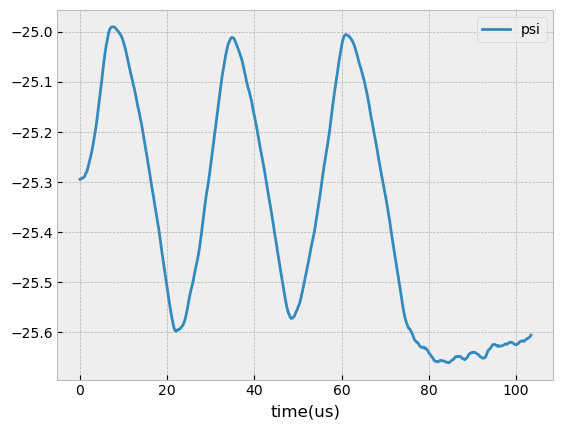

In [15]:
data_all.plot(y='psi')

<Axes: xlabel='time(us)'>

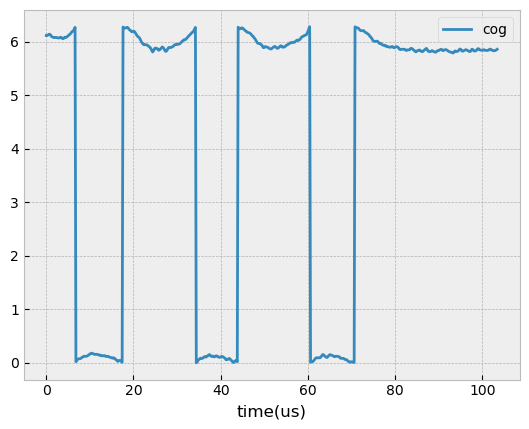

In [16]:
data.plot(y='cog')

<Axes: xlabel='time(us)'>

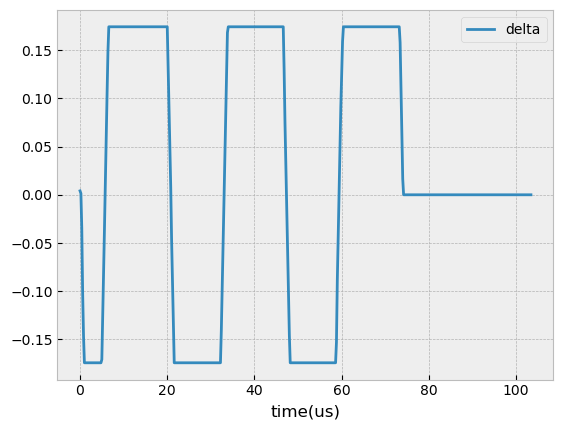

In [62]:
data.plot(y='delta')

<Axes: xlabel='time(us)'>

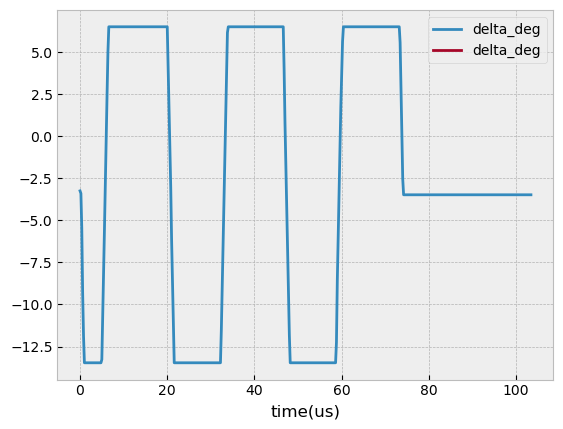

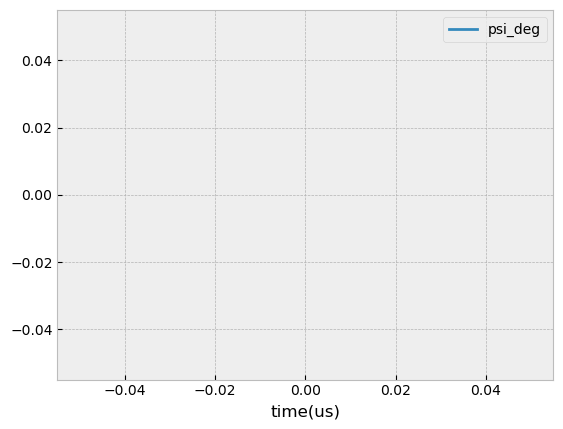

In [18]:
tolerance = 0.1
#delta = data['delta'] - (data['delta'].max() - (data['delta'].max() - data['delta'].min())/2)
    
mask = delta.abs() >= (1-tolerance)*delta.abs().max()
start = data_all.loc[mask].index[0]
end = data_all.loc[mask].index[-1]
data = data_all.iloc[data.index.get_loc(start)-15:data.index.get_loc(end)+30].copy()
#data = data.iloc[data.index.get_loc(start)+50:data.index.get_loc(end)+30].copy()


fig,ax=plt.subplots()
data_all.plot(y='delta_deg', ax=ax)
data.plot(y='delta_deg', ax=ax)
fig,ax=plt.subplots()
data.plot(y='psi_deg', ax=ax)

In [19]:
data = data_all.copy()
data.drop(columns=['mission'], inplace=True)

<Axes: xlabel='time(us)'>

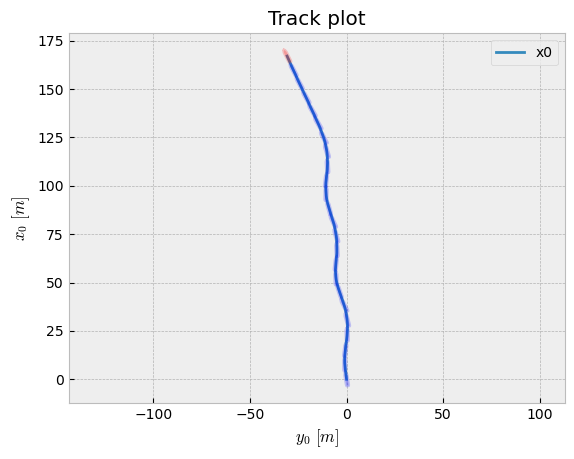

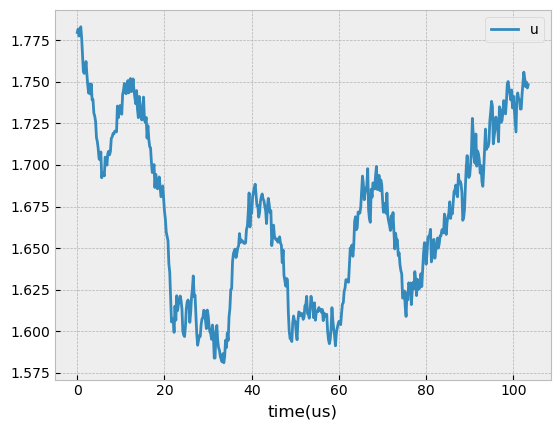

In [20]:
track_plot(df=data, lpp=ship_data['L'], beam=ship_data['B']);
data.plot(y='u')

In [21]:
model_VCT = Simulator.load("model_7m_abkowitz_simplified_VCT.pkl")
#model_VCT.parameters['Xu'] = 0
#model_VCT.parameters['Xvr'] = 0
#model_VCT.parameters['Xdeltadelta'] = 0
#model_VCT.parameters['Ydelta']*=1.5
#model_VCT.parameters['Ndelta']*=1.5
model_VCT.ship_parameters.update(ship_data)

In [22]:
parameters = initial_parameters(ship_data=ship_data)
added_masses = extract_added_masses(parameters=parameters)
model_VCT.parameters.update(added_masses)

In [23]:
model_VCT.parameters

Xudot          0.000155
Xdeltadelta    0.000000
Xu             0.000000
Xvr           -0.003068
Yrdot         -0.000286
Yvdot         -0.005820
Ydelta         0.006421
Yr             0.003643
Yvvv          -0.175645
Yv            -0.007141
Yvr            0.013694
Nrdot         -0.000280
Nvdot         -0.000110
Ndelta        -0.003099
Nrrr          -0.000281
Nr            -0.002808
Nvvv           0.008593
Nv            -0.001048
dtype: float64

## Kalman filter system matrixes (-> f(...) and jacobi matrix)

In [24]:
vmm = VMM(X_eq=model_VCT.X_eq, Y_eq = model_VCT.Y_eq, N_eq = model_VCT.N_eq)

In [25]:
system_matrixes = SystemMatrixes(vmm=vmm)

In [26]:
system_matrixes._lambda_f

<function _lambdifygenerated(v, Yr, u, Xvr, Yvdot, Yvvv, x_G, r, Nvdot, delta, m, Yv, Nrdot, Nvvv, L, Xdeltadelta, Ydelta, Yvr, Nv, I_z, Xudot, psi, Ndelta, Nrrr, Xu, Nr, rho, Yrdot)>

In [27]:
system_matrixes._lambda_jacobian

<function _lambdifygenerated(v, Yr, u, Xvr, Yvdot, Yvvv, x_G, r, Nvdot, delta, m, Yv, Nrdot, Nvvv, L, Xdeltadelta, Ydelta, Yvr, Nv, I_z, Xudot, psi, h, Nrrr, Ndelta, Xu, Nr, rho, Yrdot)>

In [28]:
model_VCT.parameters

Xudot          0.000155
Xdeltadelta    0.000000
Xu             0.000000
Xvr           -0.003068
Yrdot         -0.000286
Yvdot         -0.005820
Ydelta         0.006421
Yr             0.003643
Yvvv          -0.175645
Yv            -0.007141
Yvr            0.013694
Nrdot         -0.000280
Nvdot         -0.000110
Ndelta        -0.003099
Nrrr          -0.000281
Nr            -0.002808
Nvvv           0.008593
Nv            -0.001048
dtype: float64

## model VCT initial guessed parameters

In [29]:
#parameters = {key:value for key,value in model_VCT.parameters.items() if not 'dot' in key}
parameters = model_VCT.parameters.to_dict()

In [30]:
parameters

{'Xudot': 0.00015489731467907656,
 'Xdeltadelta': 0.0,
 'Xu': 0.0,
 'Xvr': -0.0030677925327719886,
 'Yrdot': -0.00028587921615942375,
 'Yvdot': -0.005820186864288478,
 'Ydelta': 0.006421255815780696,
 'Yr': 0.0036429893421288666,
 'Yvvv': -0.1756449904336061,
 'Yv': -0.00714112872778315,
 'Yvr': 0.01369396189020632,
 'Nrdot': -0.00027961354906602903,
 'Nvdot': -0.00010956263163164252,
 'Ndelta': -0.0030994931341465854,
 'Nrrr': -0.0002812547715010821,
 'Nr': -0.002808414520962192,
 'Nvvv': 0.008593283714686095,
 'Nv': -0.00104759589337324}

In [31]:
parameters['Nrdot']

-0.00027961354906602903

## Extended Kalman Filter

In [32]:
ek = ExtendedKalman(
        vmm=vmm,
        parameters=parameters,
        ship_parameters=ship_data,
        system_matrixes=system_matrixes,
    )

In [33]:
ek.parameters

Yvr            0.013694
Xu             0.000000
Nrrr          -0.000281
Ydelta         0.006421
Yvvv          -0.175645
Yr             0.003643
Yrdot         -0.000286
Nrdot         -0.000280
Nvdot         -0.000110
Nr            -0.002808
Nvvv           0.008593
Yvdot         -0.005820
Xvr           -0.003068
Xudot          0.000155
Xdeltadelta    0.000000
Yv            -0.007141
Ndelta        -0.003099
Nv            -0.001048
dtype: float64

In [34]:
ek.get_all_coefficients(sympy_symbols=False)

['Yvr',
 'Xu',
 'Nrrr',
 'Ydelta',
 'Yvvv',
 'Yr',
 'Yrdot',
 'Nrdot',
 'Nvdot',
 'Nr',
 'Nvvv',
 'Yvdot',
 'Xvr',
 'Xudot',
 'Xdeltadelta',
 'Yv',
 'Ndelta',
 'Nv']

In [35]:
x0 = initial_state(data)

In [36]:
x0

{'x0': 0.7295609755266923,
 'y0': -0.09584125386683695,
 'psi': -25.29272653589793,
 'u': 1.7803542391020284,
 'v': 0.01250389371056478,
 'r': 0.005300177708962519}

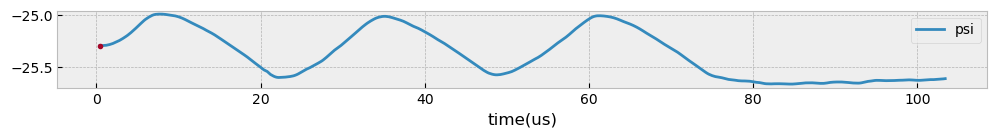

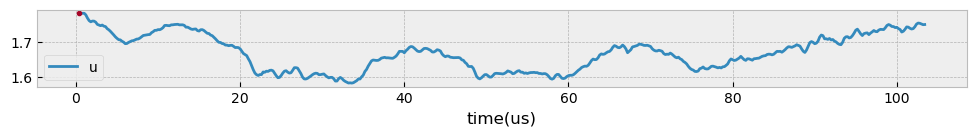

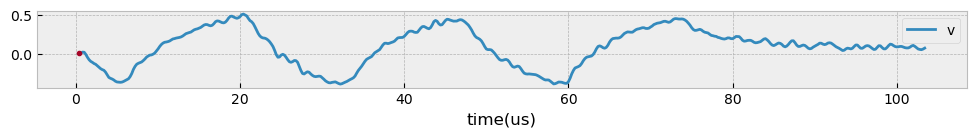

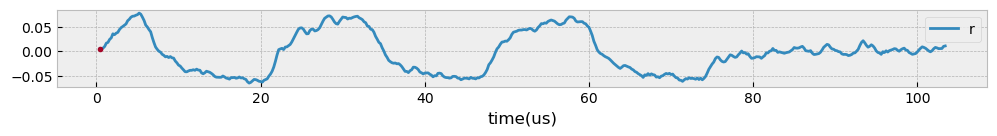

In [37]:
keys = ['psi','u','v','r']
for key in keys:
    fig,ax=plt.subplots()
    fig.set_size_inches(12,1)
    df_ = data.rolling(window=3).mean().dropna()
    df_.plot(y=key, ax=ax)
    ax.plot(df_.index[0],x0[key],'.')
    

In [38]:
ek_covariance_input = yaml.safe_load("""
process_variance:
  u : 0.003
  v : 0.3
  r : 0.019  # [deg]
measurement_error_max:
  positions: 0.05
  psi: 0.5  # [deg]
"""
)     

 
                                     
covariance_matrixes = guess_covariance_matrixes(ek_covariance_input=ek_covariance_input,data=data)
covariance_matrixes['P_prd'][3][3]/=1000

In [39]:
covariance_matrixes

{'P_prd': [[0.0002777777777777778, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 8.461594994075238e-06, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 6.023215922330105e-07, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.06023215922330105, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 6.657913462203134e-05]],
 'Qd': [[0.0006023215922330105, 0.0, 0.0],
  [0.0, 0.06023215922330105, 0.0],
  [0.0, 0.0, 6.657913462203134e-05]],
 'Rd': [[0.0002777777777777778, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0],
  [0.0, 0.0, 8.461594994075238e-06]]}

In [40]:
covariance_matrixes['P_prd']

[[0.0002777777777777778, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0002777777777777778, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 8.461594994075238e-06, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 6.023215922330105e-07, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.06023215922330105, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 6.657913462203134e-05]]

## Filter states with initially guessed model

In [41]:
x0

{'x0': 0.7295609755266923,
 'y0': -0.09584125386683695,
 'psi': -25.29272653589793,
 'u': 1.7803542391020284,
 'v': 0.01250389371056478,
 'r': 0.005300177708962519}

In [42]:
data_ = data.copy()
ek2, data_ek, time_steps = extended_kalman_filter(ek=ek, data=data, covariance_matrixes=covariance_matrixes, x0=x0, hydrodynamic_derivatives=parameters)
ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek2, data=data, time_steps=time_steps, covariance_matrixes=covariance_matrixes, hydrodynamic_derivatives=parameters)

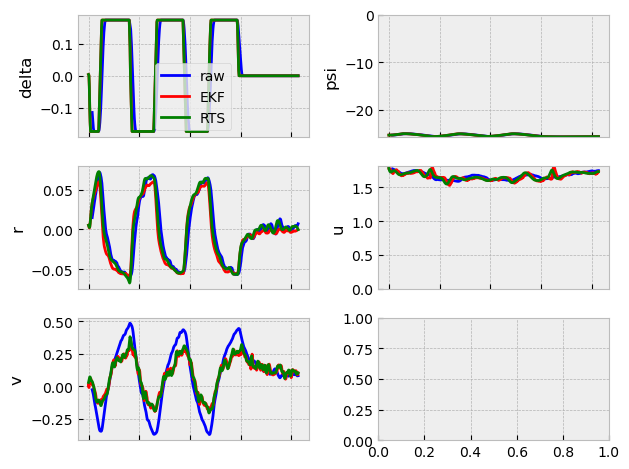

In [43]:
data_ = data.copy()

dataframes = {
'raw':data_.rolling(window=10).mean(),
'EKF':data_ek,
'RTS':data_ek_smooth,
}
plot(dataframes=dataframes, keys=['u','v','r','psi','delta']);


<Axes: xlabel='time(us)'>

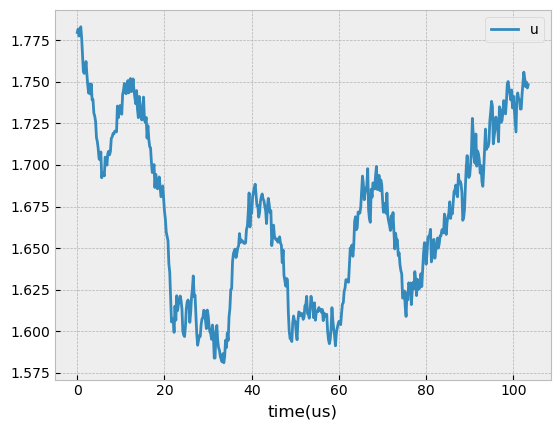

In [101]:
data.plot(y='u')

## Inverse dynamics regression

In [102]:
added_masses = extract_added_masses(parameters=parameters)

In [49]:
#data_with_force = predict_force(data=data.rolling(window=2).mean().dropna(), added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)

data_with_force = predict_force(data=data_ek_smooth, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)
#data_with_force = predict_force(data=data_ek, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)

<Axes: xlabel='delta'>

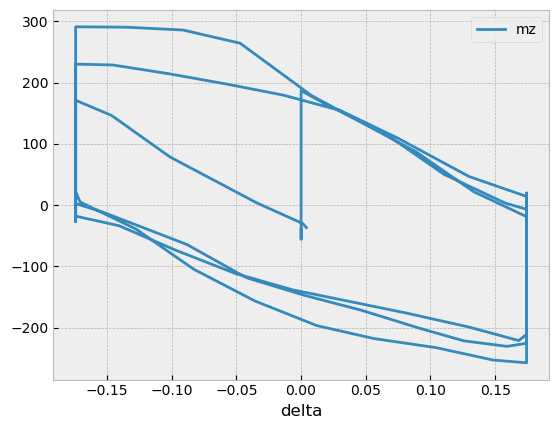

In [50]:
data_with_force.plot(x='delta', y='mz')

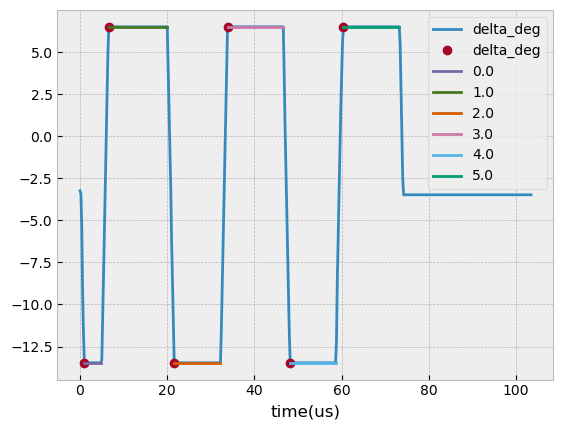

In [51]:
tolerance = 0.001
#delta = data['delta'] - (data['delta'].max() - (data['delta'].max() - data['delta'].min())/2)
    
mask = data_all['delta'].abs() >= (1-tolerance)*data_all['delta'].abs().max()
data_ = data_all.loc[mask]

dt = np.mean(np.diff(data.index))

mask = np.concatenate(([True],data_.index[1:] - data_.index[0:-1] > 2*dt))
starts = data_.loc[mask]
data_.loc[mask,'group'] = np.arange(0,len(starts))
data_['group'].fillna(method='ffill', inplace=True)
          
fig,ax=plt.subplots()
data_all.plot(y='delta_deg', ax=ax)
starts.plot(y='delta_deg', style='o', ax=ax)

for group,df_ in data_.groupby(by='group'):
    df_.plot(y='delta_deg', style='-', label=group, ax=ax)


In [52]:
start = data_.groupby(by='group').get_group(1).index[0]
end = data_.groupby(by='group').get_group(4).index[-1]
df_ = data_with_force.loc[start:end]

<Axes: >

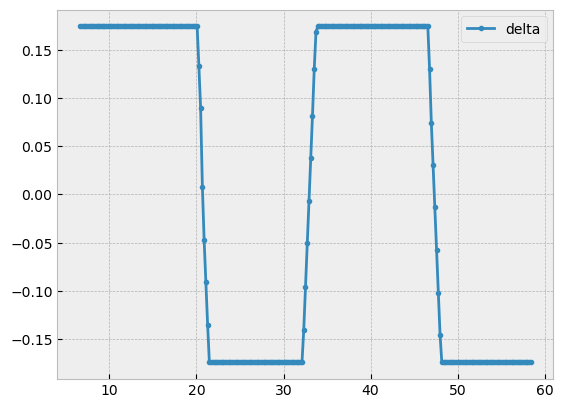

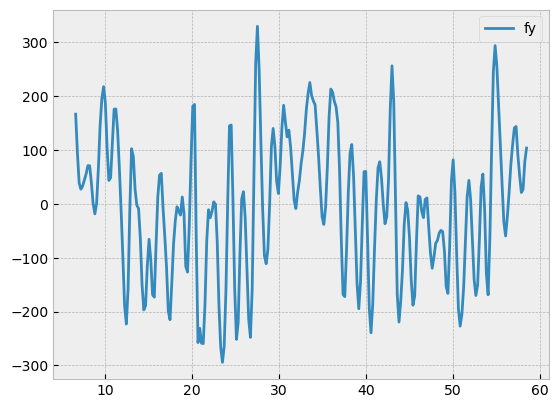

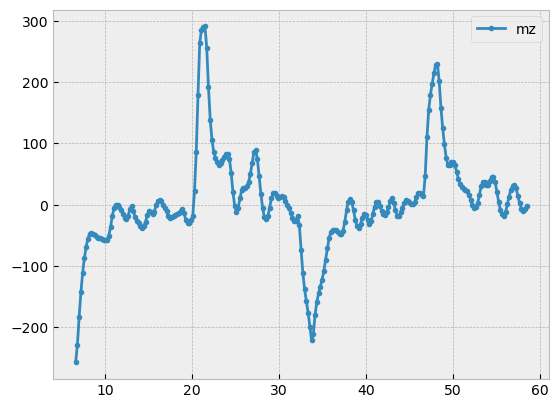

In [53]:
df_.plot(y='delta', style='.-')
df_.plot(y='fy', style='-')
df_.plot(y='mz', style='.-')

In [54]:
df_['mz'].mean()

3.5391349559085494

In [55]:
regression, derivatives = fit_motions(data=data_with_force, added_masses=added_masses, ship_data=ship_data, vmm=vmm)

In [56]:
derivatives

,regressed,$P_{value}$,$conf_{lower}$,$conf_{higher}$
Ndelta,-0.001733,4.592057e-183,-0.001807,-0.001659
Nr,-0.001737,1.651526e-105,-0.001859,-0.001616
Nrrr,0.009759,8.701942e-32,0.008235,0.011284
Nv,-0.000017,7.731705e-01,-0.000133,0.000099
Nvvv,0.005711,1.854150e-02,0.000961,0.010462
Xdeltadelta,0.000835,4.937757e-01,-0.001561,0.003231
Xu,0.000003,9.090265e-01,-0.000055,0.000062
Xvr,-0.003950,9.863710e-04,-0.006292,-0.001608
Ydelta,0.003657,NaN,NaN,NaN
Yr,0.003023,3.597430e-08,0.001962,0.004085


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fx   R-squared (uncentered):                   0.051
Model:                            OLS   Adj. R-squared (uncentered):              0.045
Method:                 Least Squares   F-statistic:                              9.162
Date:                Tue, 16 May 2023   Prob (F-statistic):                    6.48e-06
Time:                        08:32:26   Log-Likelihood:                          3338.4
No. Observations:                 516   AIC:                                     -6671.
Df Residuals:                     513   BIC:                                     -6658.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Xu           3.388e-06   2.96e-05      0.114      0.909   -5.48e-05    6.16e-05
Xdeltadelta     0.0008      0.001      0.685      0.494      -0.002       0.003
Xvr            -0.0040      0.001     -3.314      0.001      -0.006      -0.002
==============================================================================
Omnibus:                       38.375   Durbin-Watson:                   0.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.556
Skew:                          -0.310   Prob(JB):                     5.97e-25
Kurtosis:                       5.192   Cond. No.                         81.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fy   R-squared (uncentered):                   0.263
Model:                            OLS   Adj. R-squared (uncentered):              0.257
Method:                 Least Squares   F-statistic:                              45.60
Date:                Tue, 16 May 2023   Prob (F-statistic):                    9.08e-33
Time:                        08:32:26   Log-Likelihood:                          2606.3
No. Observations:                 516   AIC:                                     -5205.
Df Residuals:                     512   BIC:                                     -5188.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yv            -0.0067      0.002     -4.162      0.000      -0.010      -0.004
Yvr           -0.0043      0.005     -0.871      0.384      -0.014       0.005
Yvvv           0.0689      0.075      0.924      0.356      -0.078       0.215
Yr             0.0030      0.001      5.595      0.000       0.002       0.004
==============================================================================
Omnibus:                        1.597   Durbin-Watson:                   0.402
Prob(Omnibus):                  0.450   Jarque-Bera (JB):                1.480
Skew:                           0.013   Prob(JB):                        0.477
Kurtosis:                       2.739   Cond. No.                         197.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mz   R-squared (uncentered):                   0.858
Model:                            OLS   Adj. R-squared (uncentered):              0.856
Method:                 Least Squares   F-statistic:                              615.0
Date:                Tue, 16 May 2023   Prob (F-statistic):                   1.52e-213
Time:                        08:32:26   Log-Likelihood:                          4313.8
No. Observations:                 516   AIC:                                     -8618.
Df Residuals:                     511   BIC:                                     -8596.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ndelta        -0.0017   3.78e-05    -45.810      0.000      -0.002      -0.002
Nr            -0.0017   6.19e-05    -28.053      0.000      -0.002      -0.002
Nv           -1.7e-05   5.89e-05     -0.288      0.773      -0.000    9.88e-05
Nrrr           0.0098      0.001     12.575      0.000       0.008       0.011
Nvvv           0.0057      0.002      2.362      0.019       0.001       0.010
==============================================================================
Omnibus:                       10.173   Durbin-Watson:                   0.136
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.216
Skew:                           0.337   Prob(JB):                      0.00605
Kurtosis:                       3.144   Cond. No.                         210.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

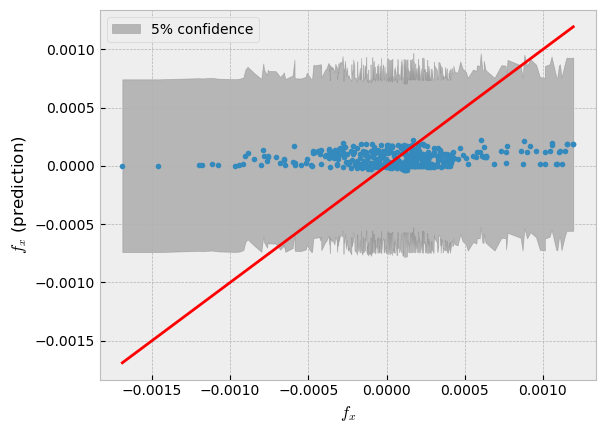

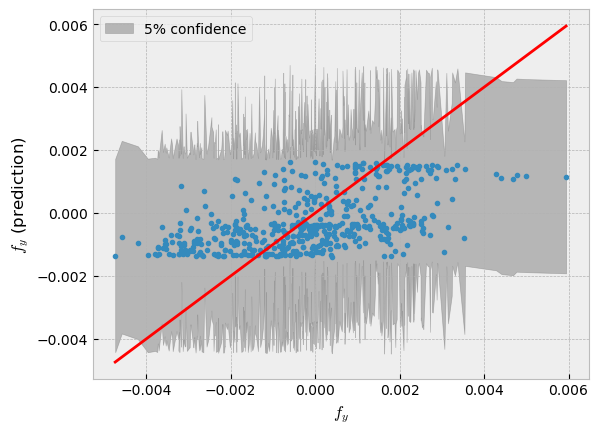

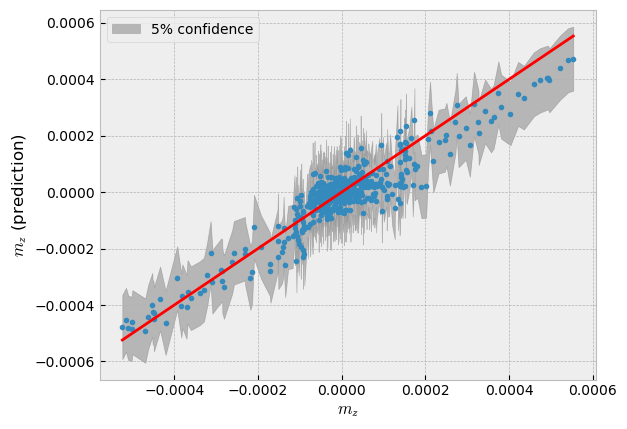

In [57]:
regression.show()

In [58]:
model = create_model_from_motion_regression(regression=regression)

In [59]:
#model.simulate(data_ek_smooth)

In [114]:
data_ = data_ek_smooth.copy()
#data_ = data_.rolling(window=10).mean().dropna()
#data_['psi']+=np.deg2rad(7)
#data_['delta']-=np.deg2rad(0.8)
data_simulated = simulate_euler(data=data_, model=model, ek=ek)
#drift = 20
#data_simulated['y0']+=drift/(data_simulated.index[-1]-data_simulated.index[0])*(data_simulated.index-data_simulated.index[0])

In [115]:
model_guess = model.copy()
model_guess.parameters = {key:parameters.get(key,0) for key in model.parameters.keys()}
data_simulated_guess = simulate_euler(data=data_ek_smooth, model=model_guess, ek=ek)

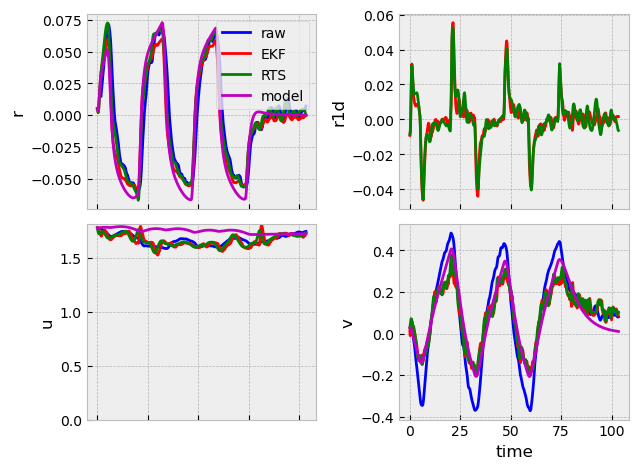

In [116]:
data_ = data.drop(columns=['v1d','r1d'])

dataframes = {
'raw':data_.rolling(window=10).mean(),
'EKF':data_ek,
'RTS':data_ek_smooth,
'model':data_simulated,
}
plot(dataframes=dataframes, keys=['u','v','r','r1d']);

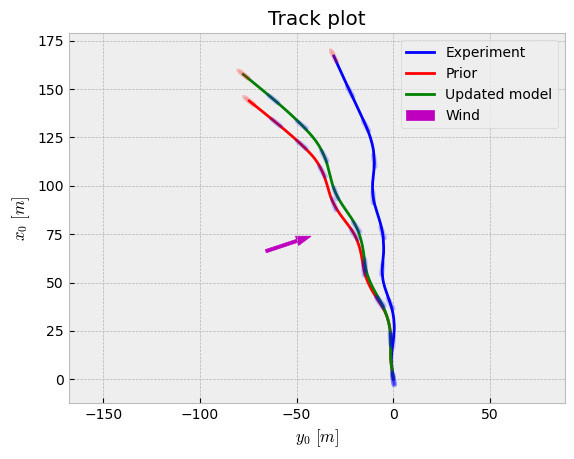

In [117]:
data['twa'] = data['twaBowRAW']
dataframes = {
'Experiment':data,
'Prior':data_simulated_guess,
'Updated model':data_simulated,
}
time_window=[0,np.inf]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], time_window=time_window, N=10);
#ax.set_xlim(-500,500)
#ax.set_ylim(-500,500)
#ax.legend(loc='lower right')



<Axes: xlabel='time(us)'>

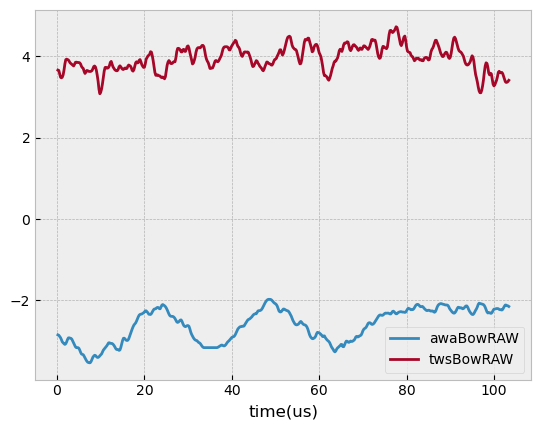

In [118]:
data.rolling(2).mean().plot(y=['awaBowRAW','twsBowRAW'])

In [119]:
data['twsBowRAW'].mean()

3.9429077519379843

In [120]:
data['awsBowRAW'].mean()

2.4473120155038757

In [121]:
awa= np.arctan2(np.mean(np.sin(data['awaBowRAW'])), np.mean(np.cos(data['awaBowRAW'])))
np.rad2deg(awa)

-149.11067634725916

In [ ]:
fig,ax=plt.subplots()
ax.plot(np.unwrap(data['awaBowRAW']),'.-')

In [ ]:
y = data['awaBowRAW'].values.copy()

i = np.argmax(np.abs(np.diff(np.unwrap(y))) > 0.5)
#mask = np.concatenate(([False],mask))
#interpolation_points = data.loc[mask]
interpolation_point = data.iloc[i+1]

fig,ax=plt.subplots()
data.plot(y='awaBowRAW', style='.-', ax=ax)
ax.plot(interpolation_point.name, interpolation_point.awaBowRAW, 'o')


In [ ]:
np.array([1,2,3]) 

In [ ]:
np.argmax((np.array([1,2,3]) > 40))

In [ ]:
np.max((np.array([1,2,3]) > 40))

In [ ]:
data_interp = fix_interpolated_angle(data=data, key='awaBowRAW', max_change=0.4)

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
data.plot(y='awaBowRAW', style='.-',ax=ax)
#data.plot(y='awaBow', style='.--', ax=ax)
data_.plot(y='awaBowRAW', style='-',ax=ax)
data_interp.plot(y='awaBowRAW', style=':',ax=ax)

In [ ]:
data_interp = fix_interpolated_angle(data=data, key='awaSternRAW', max_change=0.4)
data_interp = fix_interpolated_angle(data=data_interp, key='awaStern', max_change=0.4)
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
data.plot(y='awaSternRAW', style='.-',ax=ax)
data_interp.plot(y='awaSternRAW', style=':',ax=ax)
data_interp.plot(y='awaStern', style=':',ax=ax)

In [ ]:
data_interp = fix_interpolated_angle(data=data, key='awaBowRAW', max_change=0.4)
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
data.plot(y='awaBowRAW', style='.-',ax=ax)
data_interp.plot(y='awaBowRAW', style=':',ax=ax)

In [ ]:
data_ = data.copy()
data_.loc[interpolation_points.index]['awaBowRAW'] = np.NaN

In [ ]:
fig,ax=plt.subplots()
ax.plot(np.unwrap(data_['awaBowRAW']))

In [ ]:
exclude_parameters

In [ ]:
itterations = []
derivatives = parameters.copy()
covariance_matrixes_itterations = covariance_matrixes.copy()
exclude_parameters={}

data_ = data_ek_smooth.copy()
#data_ = data_.rolling(window=10).mean().dropna()
#data_['psi']+=np.deg2rad(1)
#data_['delta']-=np.deg2rad(0.8)

for i in range(0,5):
    
    ek2, data_ek, time_steps = extended_kalman_filter(ek=ek, data=data, covariance_matrixes=covariance_matrixes_itterations, x0=x0, hydrodynamic_derivatives=derivatives)
    ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek2, data=data, time_steps=time_steps, covariance_matrixes=covariance_matrixes_itterations, hydrodynamic_derivatives=derivatives)
    data_with_force = predict_force(data=data_ek_smooth, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)
    regression, derivatives = fit_motions(data=data_with_force, added_masses=added_masses, ship_data=ship_data, vmm=vmm, exclude_parameters=exclude_parameters)
    model = create_model_from_motion_regression(regression=regression)
    data_simulated = simulate_euler(data=data_, model=model, ek=ek_smooth)
    
    covariance_matrixes_itterations['Qd'] = np.array(covariance_matrixes_itterations['Qd'])*0.7
    
    itterations.append(
        {
            'data_ek':data_ek,
            'data_ek_smooth':data_ek_smooth,
            'derivatives':derivatives,
            'data_simulated':data_simulated,
        }
    )

In [ ]:
time_window=[0,60]
track_plots(dataframes={str(i):itteration['data_simulated'] for i,itteration in enumerate(itterations)}, lpp=ship_data['L'], beam=ship_data['B'], N=10, time_window=time_window);

In [ ]:
df_MSE = pd.DataFrame()
for dof in ['u','v','r']:
    df_MSE[dof] = pd.Series({i:mean_squared_error(y_true = data[dof], y_pred=itteration['data_simulated'][dof]) for i,itteration in enumerate(itterations)}, name=dof)

In [ ]:
fig,axess =plt.subplots(nrows=3)
for ax,dof in zip(axess,['u','v','r']):
    df_MSE.plot(y=dof, style='.-', ax=ax)
    ax.set_xticks(df_MSE.index)
ax.set_xlabel('Iterrations');


In [ ]:
dataframes = {
'Experiment':data.rolling(1).mean(),
'Prior':data_simulated_guess,
'Updated model':itterations[4]['data_simulated'],
}
time_window=[0,60]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], time_window=time_window, N=10);
#ax.get_figure().savefig("update.svg")
plot(dataframes, keys=['u','v','r','psi'], time_window=time_window);